In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

torch.Size([60000, 28, 28])
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,

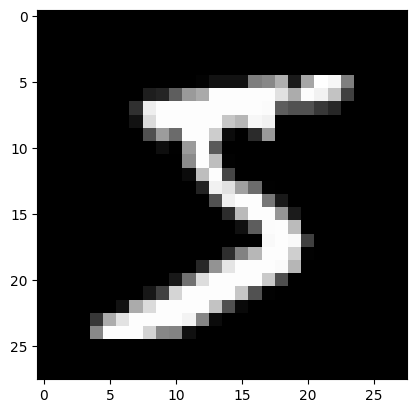

In [3]:
print(train_dataset.data.shape)
# 첫번째 데이터 출력
print(train_dataset.data[0])
# matplot 으로 출력
plt.imshow(train_dataset.data[0], cmap="gray")
print(train_dataset.targets[0])
plt.show()

In [4]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super(Encoder, self).__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128), nn.ReLU(True), nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super(Decoder, self).__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [5]:
encoder = Encoder(encoded_space_dim=2, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=2, fc2_input_dim=128)
encoder.to(device)
decoder.to(device)

params_to_optimize = [
    {"params": encoder.parameters()},
    {"params": decoder.parameters()},
]

optimizer = optim.Adam(params_to_optimize, lr=0.001, weight_decay=1e-05)
loss_fn = nn.MSELoss()
print(encoder)

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [6]:
def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0.0, 1.0)
    return noisy

torch.Size([28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


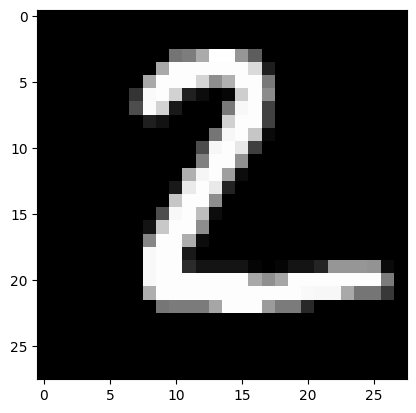

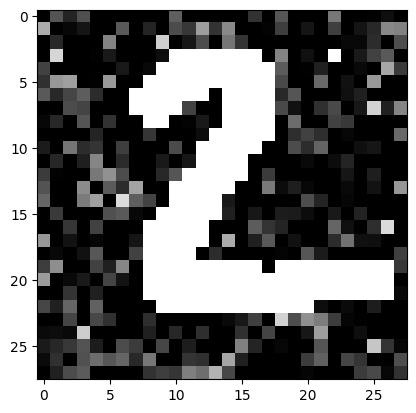

In [7]:
img = test_dataset.data[1].unsqueeze(0).float().to(device)
print(test_dataset.data[1].shape)
print(img.shape)
noisy_img = add_noise(img, noise_factor=0.3).to(device)
print(noisy_img.shape)
plt.imshow(img.cpu().squeeze().numpy(), cmap="gray")
plt.show()
plt.imshow(noisy_img.cpu().squeeze().numpy(), cmap="gray")
plt.show()
rec_img = decoder(
    encoder(test_dataset.data[0].float().to(device).reshape(1, 1, 28, 28))
)
rec_img = decoder(encoder(noisy_img.reshape(1, 1, 28, 28)))

In [8]:
def plot_ae_outputs(encoder, decoder, n=15, noise_factor=0.3):
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        img = test_dataset.data[i].unsqueeze(0).float().to(device)
        noisy_img = add_noise(img, noise_factor).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(noisy_img.reshape(-1, 1, 28, 28)))
        plt.imshow(img.cpu().squeeze().numpy(), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("Original images")
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy_img.cpu().squeeze().numpy(), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("Noisy Input")

        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("Reconstructed Input")
        plt.subplots_adjust(
            left=0.1, bottom=0.1, right=0.7, top=0.9, wspace=0.3, hspace=0.3
        )
    plt.show()

In [9]:
def train_epoch(
    encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3
):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:
        image_batch = image_batch.to(device)
        noisy_batch = add_noise(image_batch, noise_factor)
        encoded_data = encoder(noisy_batch)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [10]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noise_factor=0.3):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            noisy_batch = add_noise(image_batch, noise_factor)
            encoded_data = encoder(noisy_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

EPOCHE 1/30

 EPOCH 1/30 	 train loss 0.065 	 val loss 0.050


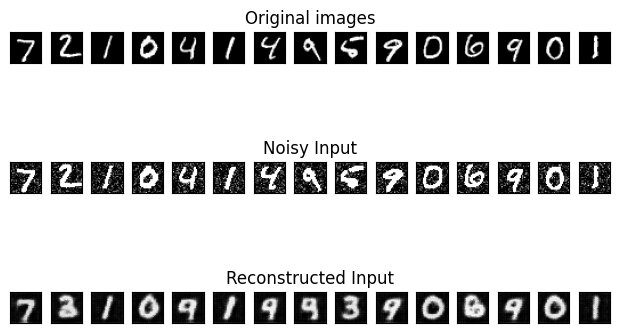

EPOCHE 2/30

 EPOCH 2/30 	 train loss 0.047 	 val loss 0.045


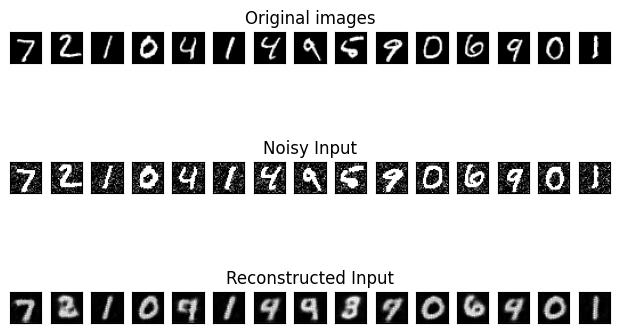

EPOCHE 3/30

 EPOCH 3/30 	 train loss 0.043 	 val loss 0.042


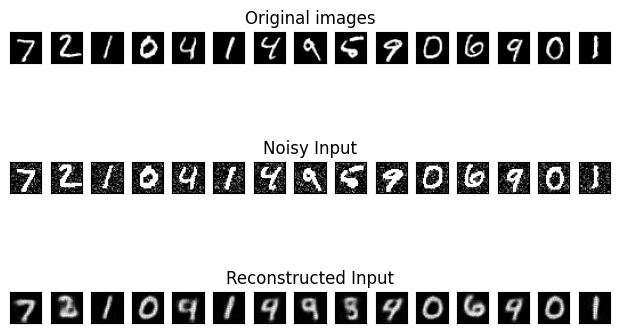

EPOCHE 4/30

 EPOCH 4/30 	 train loss 0.041 	 val loss 0.040


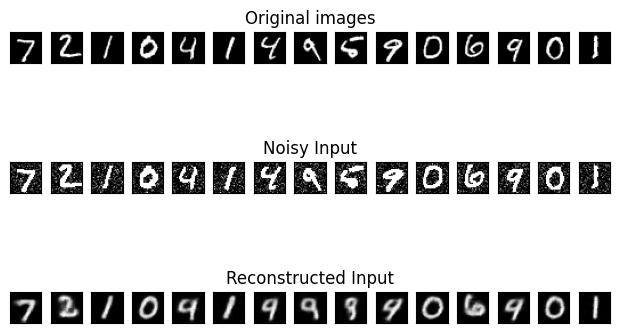

EPOCHE 5/30

 EPOCH 5/30 	 train loss 0.040 	 val loss 0.040


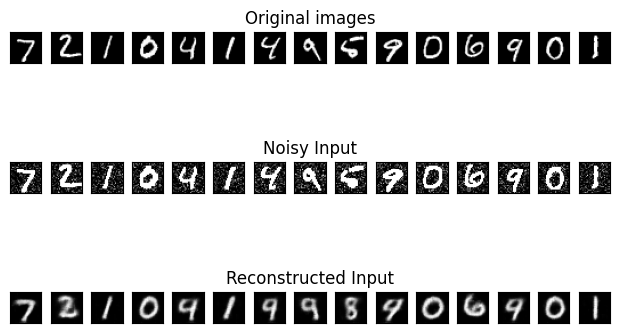

EPOCHE 6/30

 EPOCH 6/30 	 train loss 0.039 	 val loss 0.039


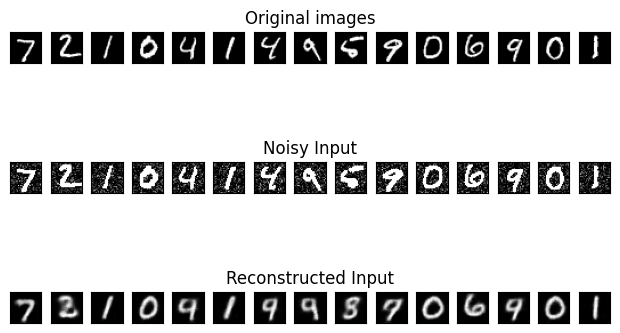

EPOCHE 7/30

 EPOCH 7/30 	 train loss 0.039 	 val loss 0.039


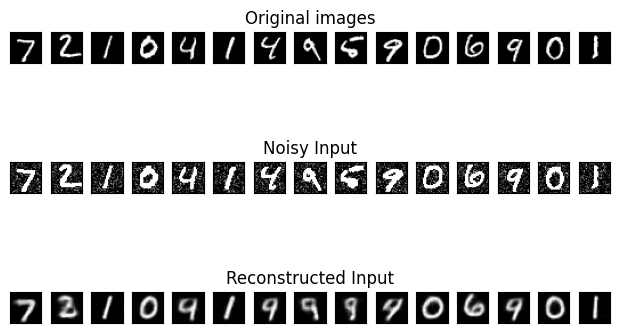

EPOCHE 8/30

 EPOCH 8/30 	 train loss 0.039 	 val loss 0.039


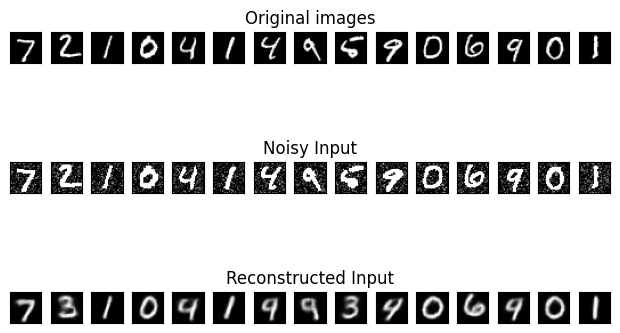

EPOCHE 9/30

 EPOCH 9/30 	 train loss 0.039 	 val loss 0.038


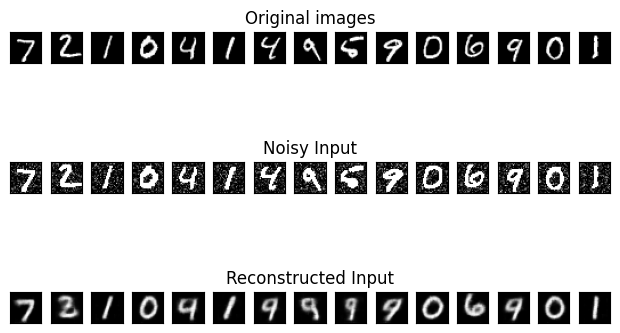

EPOCHE 10/30

 EPOCH 10/30 	 train loss 0.038 	 val loss 0.039


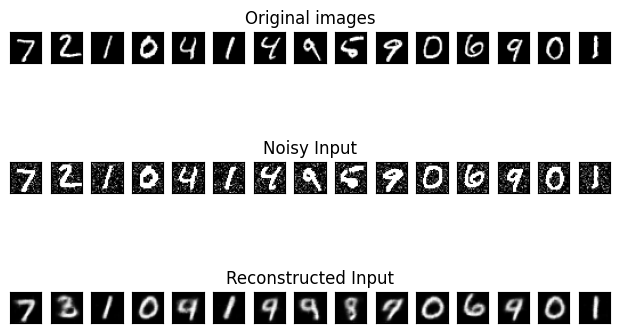

EPOCHE 11/30

 EPOCH 11/30 	 train loss 0.038 	 val loss 0.038


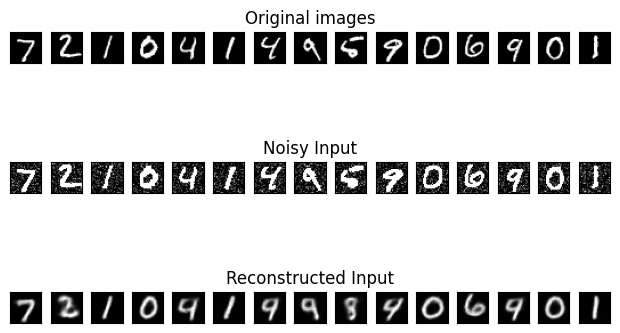

EPOCHE 12/30

 EPOCH 12/30 	 train loss 0.038 	 val loss 0.038


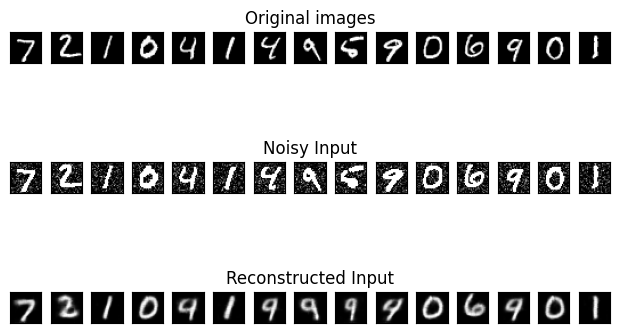

EPOCHE 13/30

 EPOCH 13/30 	 train loss 0.038 	 val loss 0.038


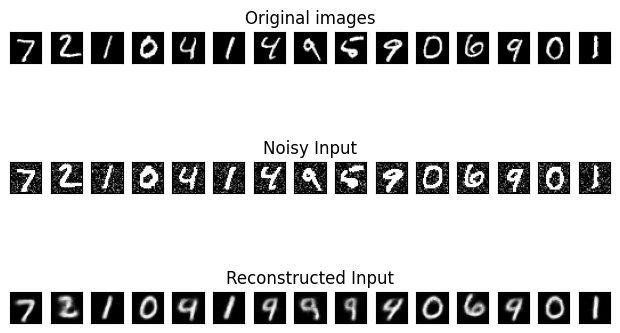

EPOCHE 14/30

 EPOCH 14/30 	 train loss 0.038 	 val loss 0.038


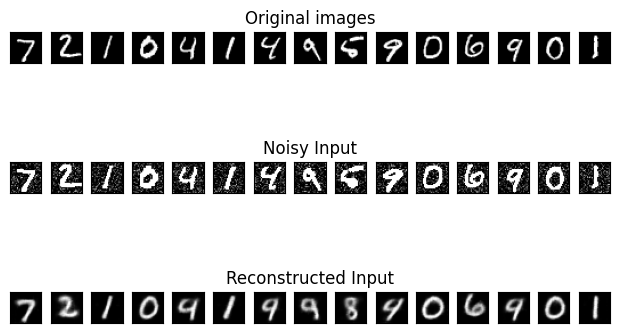

EPOCHE 15/30

 EPOCH 15/30 	 train loss 0.038 	 val loss 0.038


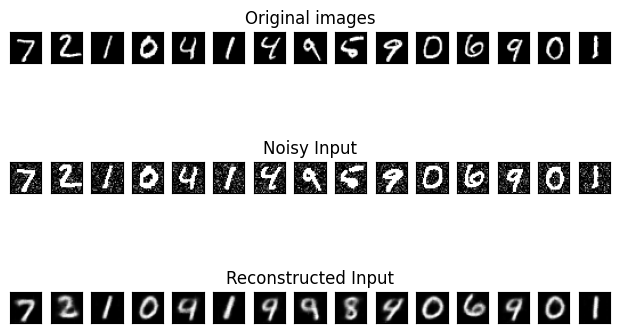

EPOCHE 16/30

 EPOCH 16/30 	 train loss 0.038 	 val loss 0.038


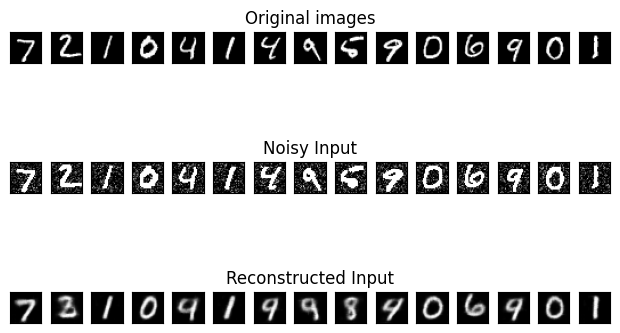

EPOCHE 17/30

 EPOCH 17/30 	 train loss 0.038 	 val loss 0.038


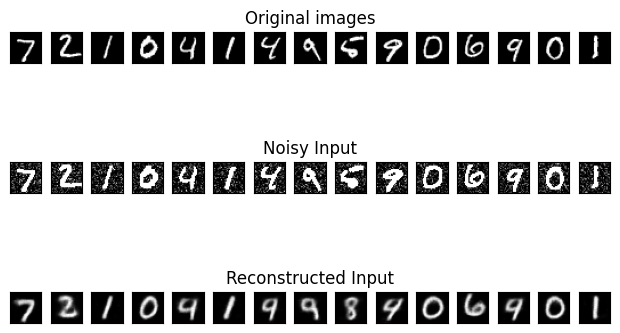

EPOCHE 18/30

 EPOCH 18/30 	 train loss 0.038 	 val loss 0.038


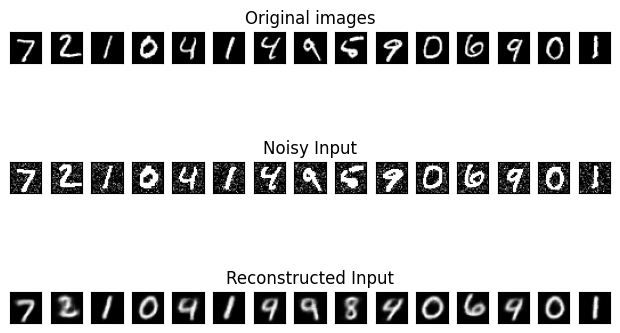

EPOCHE 19/30

 EPOCH 19/30 	 train loss 0.038 	 val loss 0.038


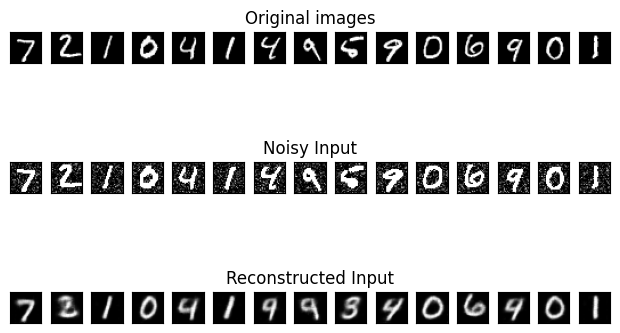

EPOCHE 20/30

 EPOCH 20/30 	 train loss 0.037 	 val loss 0.037


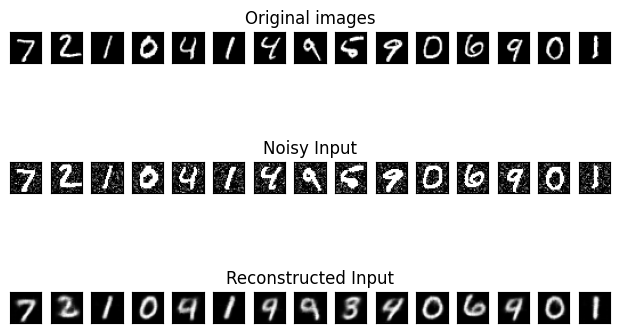

EPOCHE 21/30

 EPOCH 21/30 	 train loss 0.037 	 val loss 0.038


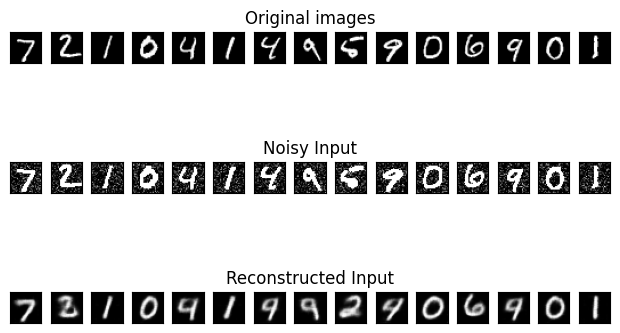

EPOCHE 22/30

 EPOCH 22/30 	 train loss 0.037 	 val loss 0.038


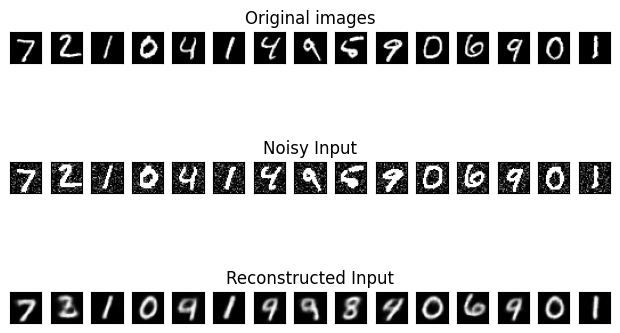

EPOCHE 23/30

 EPOCH 23/30 	 train loss 0.037 	 val loss 0.037


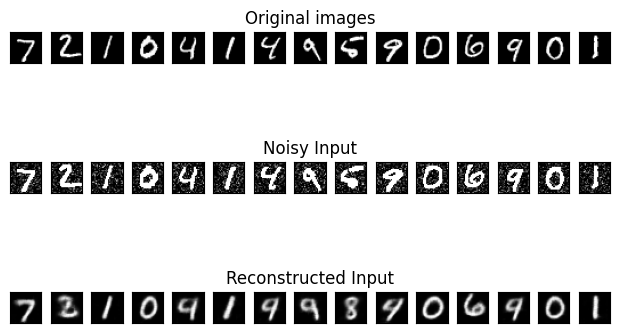

EPOCHE 24/30

 EPOCH 24/30 	 train loss 0.037 	 val loss 0.037


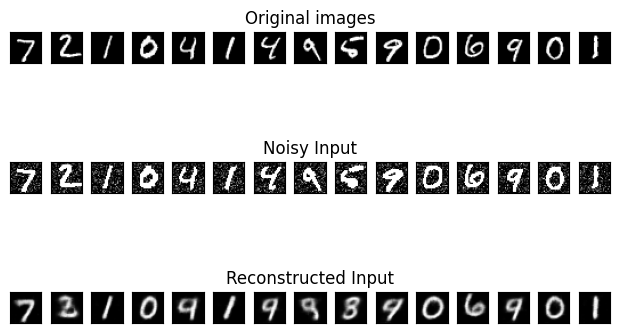

EPOCHE 25/30

 EPOCH 25/30 	 train loss 0.037 	 val loss 0.037


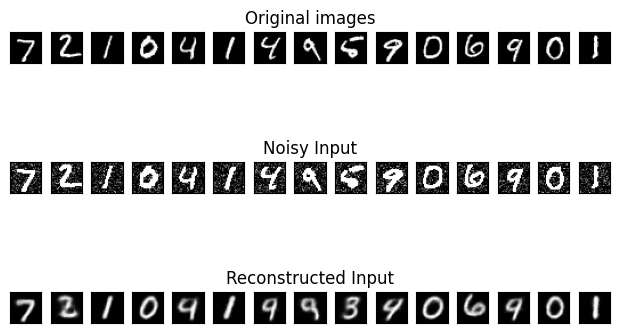

EPOCHE 26/30

 EPOCH 26/30 	 train loss 0.037 	 val loss 0.037


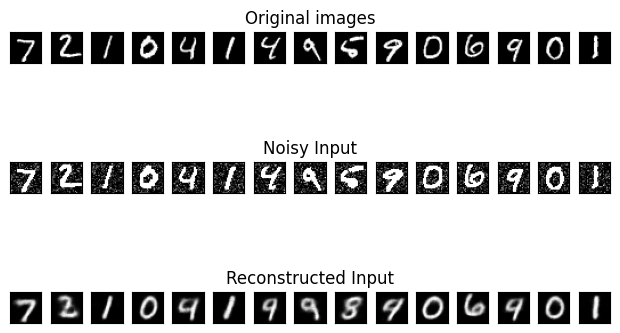

EPOCHE 27/30

 EPOCH 27/30 	 train loss 0.037 	 val loss 0.037


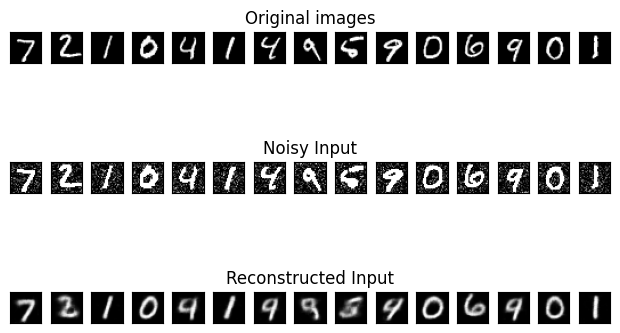

EPOCHE 28/30

 EPOCH 28/30 	 train loss 0.037 	 val loss 0.037


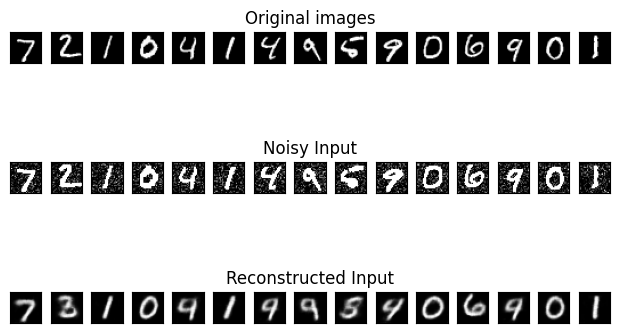

EPOCHE 29/30

 EPOCH 29/30 	 train loss 0.037 	 val loss 0.037


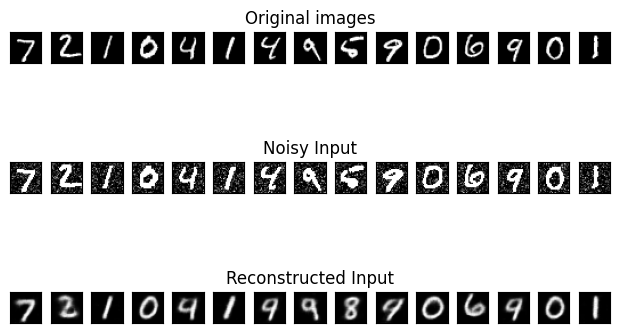

EPOCHE 30/30

 EPOCH 30/30 	 train loss 0.037 	 val loss 0.037


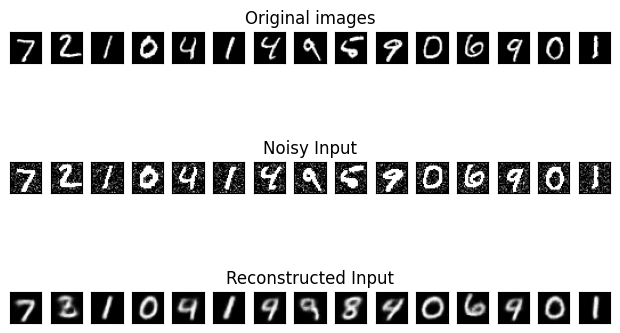

In [11]:
num_epochs = 30
history_da = {"train_loss": [], "test_loss": []}
loss_fn = nn.MSELoss()
for epoch in range(num_epochs):
    print("EPOCHE %d/%d" % (epoch + 1, num_epochs))
    train_loss = train_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        noise_factor=0.3,
    )
    val_loss = test_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=test_loader,
        loss_fn=loss_fn,
        noise_factor=0.3,
    )
    history_da["train_loss"].append(train_loss)
    history_da["test_loss"].append(val_loss)
    print(
        "\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}".format(
            epoch + 1, num_epochs, train_loss, val_loss
        )
    )
    plot_ae_outputs(encoder=encoder, decoder=decoder, noise_factor=0.3)

[0.20642663680958395, -0.6398453628006275]


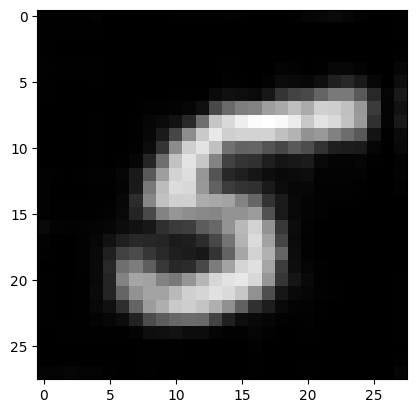

In [12]:
# 임의의 숫자를 넣어서 random 으로 decoder 만으로 숫자 그림 생성하기
import random

random_data = [random.random() * 2 - 1 for _ in range(2)]
# random_data = [0.337, 0.49]
print(random_data)
output = decoder(torch.Tensor(random_data).to(device).reshape(-1, 2))
plt.imshow(output.cpu().squeeze().detach().numpy(), cmap="gray")
plt.show()

In [13]:
# train data 로 숫자 얻기
for i in range(10):
    output = encoder(train_dataset.data[i].float().to(device).reshape(1, 1, 28, 28))
    print(train_dataset.targets[i])
    print(output)

tensor(5)
tensor([[-4.0542, -2.4262]], grad_fn=<AddmmBackward0>)
tensor(0)
tensor([[-139.1452, -231.1998]], grad_fn=<AddmmBackward0>)
tensor(4)
tensor([[-23.6494, 109.3990]], grad_fn=<AddmmBackward0>)
tensor(1)
tensor([[ 40.4893, -29.0098]], grad_fn=<AddmmBackward0>)
tensor(9)
tensor([[1.4028, 1.3478]], grad_fn=<AddmmBackward0>)
tensor(2)
tensor([[ -2.5322, -15.8455]], grad_fn=<AddmmBackward0>)
tensor(1)
tensor([[65.5203,  4.0925]], grad_fn=<AddmmBackward0>)
tensor(3)
tensor([[-1.6796, -5.8440]], grad_fn=<AddmmBackward0>)
tensor(1)
tensor([[45.4308,  0.6180]], grad_fn=<AddmmBackward0>)
tensor(4)
tensor([[18.2398, 40.0009]], grad_fn=<AddmmBackward0>)


## VAE

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [15]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input1 = nn.Linear(input_dim, hidden_dim)
        self.input2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)
        self.LeakyRelu = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        h_ = self.LeakyRelu(self.input1(x))
        h_ = self.LeakyRelu(self.input2(h_))
        mean = self.mean(h_)
        log_var = self.var(h_)
        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyRelu = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyRelu(self.hidden1(x))
        h = self.LeakyRelu(self.hidden2(h))
        return torch.sigmoid(self.output(h))


class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

In [17]:
x_dim = 784
hidden_dim = 400
latent_dim = 200
epochs = 30
batch_size = 100

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)
model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [18]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss, KLD


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [19]:

!pip install tensorboardX
# 6 model train function
from tensorboardX import SummaryWriter
saved_loc = "scalar/"
writer = SummaryWriter(saved_loc)

model.train()

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 KB 3.0 MB/s eta 0:00:00


Model(
  (Encoder): Encoder(
    (input1): Linear(in_features=784, out_features=400, bias=True)
    (input2): Linear(in_features=400, out_features=400, bias=True)
    (mean): Linear(in_features=400, out_features=200, bias=True)
    (var): Linear(in_features=400, out_features=200, bias=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (hidden1): Linear(in_features=200, out_features=400, bias=True)
    (hidden2): Linear(in_features=400, out_features=400, bias=True)
    (output): Linear(in_features=400, out_features=784, bias=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.2)
  )
)

In [20]:
model.train()


def train(epoch, model, train_loder, optimizer):
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loder):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        BCE, KLD = loss_function(x, x_hat, mean, log_var)
        loss = BCE + KLD
        writer.add_scalar(
            "Train/Reconstruction Error",
            BCE.item(),
            batch_idx + epoch * len(train_loder.dataset) / batch_size,
        )
        writer.add_scalar(
            "Train/KL-Divergence",
            KLD.item(),
            batch_idx + epoch * len(train_loder.dataset) / batch_size,
        )
        writer.add_scalar(
            "Train/Total Loss",
            loss.item(),
            batch_idx + epoch * len(train_loder.dataset) / batch_size,
        )
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(x)}/{len(train_loder.dataset)} ({100. * batch_idx / len(train_loder):.0f}%)]\tLoss: {loss.item() / len(x):.6f}"
            )
    print(
        "====> Epoch: {} Average loss: {:.4f}".format(
            epoch, train_loss / len(train_loder.dataset)
        )
    )

In [21]:
import torchvision


# 7 model test function
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)
            x_hat, mean, log_var = model(x)
            BCE, KLD = loss_function(x, x_hat, mean, log_var)
            loss = BCE + KLD

            writer.add_scalar(
                "Test/Reconstruction Error",
                BCE.item(),
                batch_idx + epoch * len(test_loader.dataset) / batch_size,
            )
            writer.add_scalar(
                "Test/KL-Divergence",
                KLD.item(),
                batch_idx + epoch * len(test_loader.dataset) / batch_size,
            )
            writer.add_scalar(
                "Test/Total Loss",
                loss.item(),
                batch_idx + epoch * len(test_loader.dataset) / batch_size,
            )
            test_loss += loss.item()

            if batch_idx == 0:
                n = min(x.size(0), 8)
                comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
                grid = torchvision.utils.make_grid(comparison.cpu())
                writer.add_image(
                    "Test image - Above: real data, below: reconstructed data",
                    grid,
                    epoch,
                )

In [22]:
# 8 model train and test
from tqdm.auto import tqdm

for epoch in tqdm(range(0, epochs)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)
    print("\n")
writer.close()

/home/lws/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	Loss: 545.522852
Train Epoch: 0 [10000/60000 (17%)]	Loss: 199.028418
Train Epoch: 0 [20000/60000 (33%)]	Loss: 186.439668
Train Epoch: 0 [30000/60000 (50%)]	Loss: 167.364062
Train Epoch: 0 [40000/60000 (67%)]	Loss: 159.953789
Train Epoch: 0 [50000/60000 (83%)]	Loss: 148.261475
====> Epoch: 0 Average loss: 173.9778


  3%|▎         | 1/30 [00:35<17:06, 35.40s/it]



Train Epoch: 1 [0/60000 (0%)]	Loss: 147.591709
Train Epoch: 1 [10000/60000 (17%)]	Loss: 135.657988
Train Epoch: 1 [20000/60000 (33%)]	Loss: 129.038623
Train Epoch: 1 [30000/60000 (50%)]	Loss: 132.532891
Train Epoch: 1 [40000/60000 (67%)]	Loss: 125.640586
Train Epoch: 1 [50000/60000 (83%)]	Loss: 120.257676
====> Epoch: 1 Average loss: 129.8223


  7%|▋         | 2/30 [01:02<14:13, 30.50s/it]



Train Epoch: 2 [0/60000 (0%)]	Loss: 119.690352
Train Epoch: 2 [10000/60000 (17%)]	Loss: 121.639678
Train Epoch: 2 [20000/60000 (33%)]	Loss: 121.750498
Train Epoch: 2 [30000/60000 (50%)]	Loss: 118.655322
Train Epoch: 2 [40000/60000 (67%)]	Loss: 111.465449
Train Epoch: 2 [50000/60000 (83%)]	Loss: 115.063242
====> Epoch: 2 Average loss: 116.9780


 10%|█         | 3/30 [01:29<13:01, 28.94s/it]



Train Epoch: 3 [0/60000 (0%)]	Loss: 115.634336
Train Epoch: 3 [10000/60000 (17%)]	Loss: 110.292412
Train Epoch: 3 [20000/60000 (33%)]	Loss: 114.213359
Train Epoch: 3 [30000/60000 (50%)]	Loss: 110.400723
Train Epoch: 3 [40000/60000 (67%)]	Loss: 109.052207
Train Epoch: 3 [50000/60000 (83%)]	Loss: 109.415293
====> Epoch: 3 Average loss: 112.3466


 13%|█▎        | 4/30 [01:59<12:45, 29.46s/it]



Train Epoch: 4 [0/60000 (0%)]	Loss: 111.917207
Train Epoch: 4 [10000/60000 (17%)]	Loss: 111.679883
Train Epoch: 4 [20000/60000 (33%)]	Loss: 113.149316
Train Epoch: 4 [30000/60000 (50%)]	Loss: 111.164473
Train Epoch: 4 [40000/60000 (67%)]	Loss: 110.977109
Train Epoch: 4 [50000/60000 (83%)]	Loss: 112.464785
====> Epoch: 4 Average loss: 109.8028


 17%|█▋        | 5/30 [02:28<12:06, 29.07s/it]



Train Epoch: 5 [0/60000 (0%)]	Loss: 103.007363
Train Epoch: 5 [10000/60000 (17%)]	Loss: 107.766855
Train Epoch: 5 [20000/60000 (33%)]	Loss: 114.142109
Train Epoch: 5 [30000/60000 (50%)]	Loss: 105.099229
Train Epoch: 5 [40000/60000 (67%)]	Loss: 107.897930
Train Epoch: 5 [50000/60000 (83%)]	Loss: 106.608633
====> Epoch: 5 Average loss: 108.0929


 20%|██        | 6/30 [02:55<11:22, 28.45s/it]



Train Epoch: 6 [0/60000 (0%)]	Loss: 105.944824
Train Epoch: 6 [10000/60000 (17%)]	Loss: 105.016689
Train Epoch: 6 [20000/60000 (33%)]	Loss: 106.017246
Train Epoch: 6 [30000/60000 (50%)]	Loss: 104.671465
Train Epoch: 6 [40000/60000 (67%)]	Loss: 104.832539
Train Epoch: 6 [50000/60000 (83%)]	Loss: 108.759531
====> Epoch: 6 Average loss: 106.8655


 23%|██▎       | 7/30 [03:23<10:54, 28.45s/it]



Train Epoch: 7 [0/60000 (0%)]	Loss: 101.771611
Train Epoch: 7 [10000/60000 (17%)]	Loss: 103.766777
Train Epoch: 7 [20000/60000 (33%)]	Loss: 109.637734
Train Epoch: 7 [30000/60000 (50%)]	Loss: 106.922295
Train Epoch: 7 [40000/60000 (67%)]	Loss: 107.328408
Train Epoch: 7 [50000/60000 (83%)]	Loss: 104.013184
====> Epoch: 7 Average loss: 106.0621


 27%|██▋       | 8/30 [03:53<10:31, 28.71s/it]



Train Epoch: 8 [0/60000 (0%)]	Loss: 102.573115
Train Epoch: 8 [10000/60000 (17%)]	Loss: 111.147295
Train Epoch: 8 [20000/60000 (33%)]	Loss: 107.309980
Train Epoch: 8 [30000/60000 (50%)]	Loss: 107.428604
Train Epoch: 8 [40000/60000 (67%)]	Loss: 101.234648
Train Epoch: 8 [50000/60000 (83%)]	Loss: 101.542617
====> Epoch: 8 Average loss: 105.2718


 30%|███       | 9/30 [04:21<10:02, 28.71s/it]



Train Epoch: 9 [0/60000 (0%)]	Loss: 104.974980
Train Epoch: 9 [10000/60000 (17%)]	Loss: 107.802402
Train Epoch: 9 [20000/60000 (33%)]	Loss: 109.407910
Train Epoch: 9 [30000/60000 (50%)]	Loss: 108.213418
Train Epoch: 9 [40000/60000 (67%)]	Loss: 104.094688
Train Epoch: 9 [50000/60000 (83%)]	Loss: 103.875547
====> Epoch: 9 Average loss: 104.6852


 33%|███▎      | 10/30 [04:56<10:07, 30.39s/it]



Train Epoch: 10 [0/60000 (0%)]	Loss: 103.326719
Train Epoch: 10 [10000/60000 (17%)]	Loss: 104.224736
Train Epoch: 10 [20000/60000 (33%)]	Loss: 104.113027
Train Epoch: 10 [30000/60000 (50%)]	Loss: 97.982988
Train Epoch: 10 [40000/60000 (67%)]	Loss: 104.722402
Train Epoch: 10 [50000/60000 (83%)]	Loss: 105.558389
====> Epoch: 10 Average loss: 104.1637


 37%|███▋      | 11/30 [05:42<11:12, 35.38s/it]



Train Epoch: 11 [0/60000 (0%)]	Loss: 104.555566
Train Epoch: 11 [10000/60000 (17%)]	Loss: 103.778184
Train Epoch: 11 [20000/60000 (33%)]	Loss: 106.724170
Train Epoch: 11 [30000/60000 (50%)]	Loss: 105.610332
Train Epoch: 11 [40000/60000 (67%)]	Loss: 104.927266
Train Epoch: 11 [50000/60000 (83%)]	Loss: 102.918242
====> Epoch: 11 Average loss: 103.7022


 40%|████      | 12/30 [06:12<10:05, 33.63s/it]



Train Epoch: 12 [0/60000 (0%)]	Loss: 102.508008
Train Epoch: 12 [10000/60000 (17%)]	Loss: 97.597480
Train Epoch: 12 [20000/60000 (33%)]	Loss: 103.334336
Train Epoch: 12 [30000/60000 (50%)]	Loss: 97.462090
Train Epoch: 12 [40000/60000 (67%)]	Loss: 104.478672
Train Epoch: 12 [50000/60000 (83%)]	Loss: 100.881182
====> Epoch: 12 Average loss: 103.3614


 43%|████▎     | 13/30 [06:42<09:12, 32.52s/it]



Train Epoch: 13 [0/60000 (0%)]	Loss: 102.904043
Train Epoch: 13 [10000/60000 (17%)]	Loss: 100.957910
Train Epoch: 13 [20000/60000 (33%)]	Loss: 102.437500
Train Epoch: 13 [30000/60000 (50%)]	Loss: 100.349980
Train Epoch: 13 [40000/60000 (67%)]	Loss: 101.369121
Train Epoch: 13 [50000/60000 (83%)]	Loss: 101.133066
====> Epoch: 13 Average loss: 102.9838


 47%|████▋     | 14/30 [07:12<08:27, 31.71s/it]



Train Epoch: 14 [0/60000 (0%)]	Loss: 105.820068
Train Epoch: 14 [10000/60000 (17%)]	Loss: 99.880254
Train Epoch: 14 [20000/60000 (33%)]	Loss: 100.128506
Train Epoch: 14 [30000/60000 (50%)]	Loss: 100.946494
Train Epoch: 14 [40000/60000 (67%)]	Loss: 102.107021
Train Epoch: 14 [50000/60000 (83%)]	Loss: 98.385996
====> Epoch: 14 Average loss: 102.6426


 50%|█████     | 15/30 [07:43<07:53, 31.58s/it]



Train Epoch: 15 [0/60000 (0%)]	Loss: 102.379902
Train Epoch: 15 [10000/60000 (17%)]	Loss: 103.645459
Train Epoch: 15 [20000/60000 (33%)]	Loss: 101.909893
Train Epoch: 15 [30000/60000 (50%)]	Loss: 103.113467
Train Epoch: 15 [40000/60000 (67%)]	Loss: 105.277500
Train Epoch: 15 [50000/60000 (83%)]	Loss: 100.499004
====> Epoch: 15 Average loss: 102.4375


 53%|█████▎    | 16/30 [08:15<07:24, 31.73s/it]



Train Epoch: 16 [0/60000 (0%)]	Loss: 101.075898
Train Epoch: 16 [10000/60000 (17%)]	Loss: 103.632822
Train Epoch: 16 [20000/60000 (33%)]	Loss: 102.518545
Train Epoch: 16 [30000/60000 (50%)]	Loss: 102.451992
Train Epoch: 16 [40000/60000 (67%)]	Loss: 102.625186
Train Epoch: 16 [50000/60000 (83%)]	Loss: 107.132441
====> Epoch: 16 Average loss: 102.1167


 57%|█████▋    | 17/30 [08:46<06:47, 31.37s/it]



Train Epoch: 17 [0/60000 (0%)]	Loss: 104.229160
Train Epoch: 17 [10000/60000 (17%)]	Loss: 101.371680
Train Epoch: 17 [20000/60000 (33%)]	Loss: 104.063242
Train Epoch: 17 [30000/60000 (50%)]	Loss: 103.795254
Train Epoch: 17 [40000/60000 (67%)]	Loss: 103.279648
Train Epoch: 17 [50000/60000 (83%)]	Loss: 102.108369
====> Epoch: 17 Average loss: 101.9227


 60%|██████    | 18/30 [09:16<06:12, 31.06s/it]



Train Epoch: 18 [0/60000 (0%)]	Loss: 105.129082
Train Epoch: 18 [10000/60000 (17%)]	Loss: 102.292187
Train Epoch: 18 [20000/60000 (33%)]	Loss: 100.862090
Train Epoch: 18 [30000/60000 (50%)]	Loss: 100.010391
Train Epoch: 18 [40000/60000 (67%)]	Loss: 99.314619
Train Epoch: 18 [50000/60000 (83%)]	Loss: 100.351738
====> Epoch: 18 Average loss: 101.7297


 63%|██████▎   | 19/30 [10:01<06:28, 35.31s/it]



Train Epoch: 19 [0/60000 (0%)]	Loss: 103.400215
Train Epoch: 19 [10000/60000 (17%)]	Loss: 99.000869
Train Epoch: 19 [20000/60000 (33%)]	Loss: 104.795293
Train Epoch: 19 [30000/60000 (50%)]	Loss: 104.978066
Train Epoch: 19 [40000/60000 (67%)]	Loss: 98.288867
Train Epoch: 19 [50000/60000 (83%)]	Loss: 100.525908
====> Epoch: 19 Average loss: 101.5091


 67%|██████▋   | 20/30 [10:23<05:13, 31.35s/it]



Train Epoch: 20 [0/60000 (0%)]	Loss: 103.343096
Train Epoch: 20 [10000/60000 (17%)]	Loss: 102.508145
Train Epoch: 20 [20000/60000 (33%)]	Loss: 100.616719
Train Epoch: 20 [30000/60000 (50%)]	Loss: 100.427891
Train Epoch: 20 [40000/60000 (67%)]	Loss: 100.606699
Train Epoch: 20 [50000/60000 (83%)]	Loss: 104.045986
====> Epoch: 20 Average loss: 101.3043


 70%|███████   | 21/30 [10:47<04:22, 29.12s/it]



Train Epoch: 21 [0/60000 (0%)]	Loss: 101.337422
Train Epoch: 21 [10000/60000 (17%)]	Loss: 101.065000
Train Epoch: 21 [20000/60000 (33%)]	Loss: 94.916758
Train Epoch: 21 [30000/60000 (50%)]	Loss: 103.810684
Train Epoch: 21 [40000/60000 (67%)]	Loss: 97.783223
Train Epoch: 21 [50000/60000 (83%)]	Loss: 106.921367
====> Epoch: 21 Average loss: 101.2016


 73%|███████▎  | 22/30 [11:08<03:33, 26.66s/it]



Train Epoch: 22 [0/60000 (0%)]	Loss: 100.476396
Train Epoch: 22 [10000/60000 (17%)]	Loss: 97.231221
Train Epoch: 22 [20000/60000 (33%)]	Loss: 105.587676
Train Epoch: 22 [30000/60000 (50%)]	Loss: 105.247686
Train Epoch: 22 [40000/60000 (67%)]	Loss: 105.852314
Train Epoch: 22 [50000/60000 (83%)]	Loss: 102.637002
====> Epoch: 22 Average loss: 100.9964


 77%|███████▋  | 23/30 [11:29<02:53, 24.85s/it]



Train Epoch: 23 [0/60000 (0%)]	Loss: 102.725195
Train Epoch: 23 [10000/60000 (17%)]	Loss: 101.190947
Train Epoch: 23 [20000/60000 (33%)]	Loss: 99.540625
Train Epoch: 23 [30000/60000 (50%)]	Loss: 98.154404
Train Epoch: 23 [40000/60000 (67%)]	Loss: 104.737773
Train Epoch: 23 [50000/60000 (83%)]	Loss: 96.654219
====> Epoch: 23 Average loss: 100.9183


 80%|████████  | 24/30 [11:50<02:22, 23.67s/it]



Train Epoch: 24 [0/60000 (0%)]	Loss: 101.596875
Train Epoch: 24 [10000/60000 (17%)]	Loss: 105.052891
Train Epoch: 24 [20000/60000 (33%)]	Loss: 96.154258
Train Epoch: 24 [30000/60000 (50%)]	Loss: 99.952344
Train Epoch: 24 [40000/60000 (67%)]	Loss: 97.567090
Train Epoch: 24 [50000/60000 (83%)]	Loss: 97.889785
====> Epoch: 24 Average loss: 100.7690


 83%|████████▎ | 25/30 [12:10<01:53, 22.61s/it]



Train Epoch: 25 [0/60000 (0%)]	Loss: 100.708486
Train Epoch: 25 [10000/60000 (17%)]	Loss: 98.772559
Train Epoch: 25 [20000/60000 (33%)]	Loss: 101.909688
Train Epoch: 25 [30000/60000 (50%)]	Loss: 101.797930
Train Epoch: 25 [40000/60000 (67%)]	Loss: 97.858330
Train Epoch: 25 [50000/60000 (83%)]	Loss: 98.745283
====> Epoch: 25 Average loss: 100.5806


 87%|████████▋ | 26/30 [12:30<01:27, 21.92s/it]



Train Epoch: 26 [0/60000 (0%)]	Loss: 99.724609
Train Epoch: 26 [10000/60000 (17%)]	Loss: 102.854727
Train Epoch: 26 [20000/60000 (33%)]	Loss: 101.534463
Train Epoch: 26 [30000/60000 (50%)]	Loss: 100.609053
Train Epoch: 26 [40000/60000 (67%)]	Loss: 99.322031
Train Epoch: 26 [50000/60000 (83%)]	Loss: 101.300586
====> Epoch: 26 Average loss: 100.4773


 90%|█████████ | 27/30 [12:51<01:04, 21.59s/it]



Train Epoch: 27 [0/60000 (0%)]	Loss: 102.378711
Train Epoch: 27 [10000/60000 (17%)]	Loss: 99.282119
Train Epoch: 27 [20000/60000 (33%)]	Loss: 101.752002
Train Epoch: 27 [30000/60000 (50%)]	Loss: 102.760098
Train Epoch: 27 [40000/60000 (67%)]	Loss: 98.461523
Train Epoch: 27 [50000/60000 (83%)]	Loss: 100.563164
====> Epoch: 27 Average loss: 100.4193


 93%|█████████▎| 28/30 [13:11<00:42, 21.16s/it]



Train Epoch: 28 [0/60000 (0%)]	Loss: 103.145361
Train Epoch: 28 [10000/60000 (17%)]	Loss: 98.156729
Train Epoch: 28 [20000/60000 (33%)]	Loss: 104.156123
Train Epoch: 28 [30000/60000 (50%)]	Loss: 99.820020
Train Epoch: 28 [40000/60000 (67%)]	Loss: 103.177441
Train Epoch: 28 [50000/60000 (83%)]	Loss: 100.392988
====> Epoch: 28 Average loss: 100.3796


 97%|█████████▋| 29/30 [13:31<00:20, 20.87s/it]



Train Epoch: 29 [0/60000 (0%)]	Loss: 100.785410
Train Epoch: 29 [10000/60000 (17%)]	Loss: 102.558340
Train Epoch: 29 [20000/60000 (33%)]	Loss: 101.270264
Train Epoch: 29 [30000/60000 (50%)]	Loss: 96.338047
Train Epoch: 29 [40000/60000 (67%)]	Loss: 104.400098
Train Epoch: 29 [50000/60000 (83%)]	Loss: 100.279873
====> Epoch: 29 Average loss: 100.2528


100%|██████████| 30/30 [13:52<00:00, 27.75s/it]